# Extracción datos de https://sorare.com/football, mediante API

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import argparse

**Definiciones:**
* **Rarities**: tipo de cartas : { unique , super_rare , rare , limited , common }

* **Positions** : Posiciones del jugador : { Coach , Defender , Forward , Goalkeeper , Midfielder y Unknown }

* **Ligas** : Lista con las ligas : { BUNDESLIGA , SERIE_A , PREMIER_LEAGUE, LIGUE_1 , LA_LIGA }

**Extracción de data por query mediante Api proporcionado por SORARE**
* Diccionario de ligas
* Query: extrae nombre jugador, edad, equipo, posición y valor en ETH
* Se extraen solo 50 registros por cada query.
* función go_scout() : ejecuta la query con tres variables, rarity, position y equipos de cada liga, crea un dataframe df

In [2]:
BUNDESLIGA =["bayern-munchen-munchen","borussia-dortmund-dortmund","rb-leipzig-leipzig",
                  "union-berlin-berlin","freiburg-freiburg-im-breisgau","eintracht-frankfurt-frankfurt-am-main",
                  "wolfsburg-wolfsburg","borussia-m-gladbach-monchengladbach","bayer-leverkusen-leverkusen",
                  "werder-bremen-bremen","mainz-05-mainz","koln-koln",
                  "hoffenheim-sinsheim","augsburg-augsburg","stuttgart-stuttgart",
                  "bochum-bochum","hertha-bsc-berlin","schalke-04-gelsenkirchen"]

SERIE_A = ["juventus-torino","napoli-castel-volturno","milan-milano",
                "internazionale-milano","atalanta-ciserano","lazio-formello",
                "roma-roma","udinese-udine","torino-torino",
                "bologna-bologna","empoli-empoli","fiorentina-firenze",
                "monza-monza","salernitana-salerno","lecce-lecce",
                "spezia-la-spezia","sassuolo-sassuolo","hellas-verona-verona",
                "sampdoria-genova","cremonese-cremona"]

PREMIER_LEAGUE = ["afc-bournemouth-bournemouth-dorset","arsenal-london","aston-villa-birmingham","brentford-brentford-middlesex",
                    "brighton-hove-albion-brighton-east-sussex","burnley-burnley-lancashire","chelsea-london","coventry-city-coventry",
                    "crystal-palace-london","everton-liverpool","fulham-london","liverpool-liverpool","luton-town-luton-bedfordshire",
                    "manchester-city-manchester","manchester-united-manchester","millwall-london","newcastle-united-newcastle-upon-tyne",
                    "norwich-city-norwich-norfolk","nottingham-forest-nottingham","sheffield-united-sheffield","tottenham-hotspur-london",
                    "watford-watford","west-ham-united-london","wolverhampton-wanderers-wolverhampton"]

LIGUE_1 = ["ajaccio-ajaccio","auxerre-auxerre","amiens-sc-amiens","dijon-dijon","guingamp-guingamp","bordeaux-le-haillan","lorient-ploemeur",
               "nantes-la-chapelle-sur-erdre","sochaux-montbeliard","grenoble-foot-38-grenoble","olympique-lyonnais-lyon","paris-paris",
               "strasbourg-strasbourg","rodez-onet-le-chateau","bastia-furiani","brest-brest","reims-reims","caen-caen","rennes-rennes","toulouse-toulouse"]

LA_LIGA = ["alcorcon-alcorcon","albacete-albacete","athletic-club-bilbao","burgos-burgos","osasuna-pamplona-irunea","cadiz-cadiz","eldense-elda","leganes-leganes",
                "mirandes-miranda-de-ebro","tenerife-santa-cruz-de-tenerife","atletico-madrid-madrid","deportivo-alaves-vitoria-gasteiz","fc-andorra",
                "barcelona-barcelona","fc-cartagena-cartagena","getafe-getafe-madrid","girona-girona","granada-granada","levante-valencia","racing-ferrol-ferrol",
                "rayo-vallecano-madrid","real-betis-sevilla","celta-de-vigo-vigo","mallorca-palma-de-mallorca","real-madrid-madrid","real-oviedo-oviedo",
                "racing-santander-santander","real-sociedad-donostia-san-sebastian","sporting-gijon-gijon","real-valladolid-valladolid","real-zaragoza-zaragoza",
                "espanyol-barcelona","amorebieta-amorebieta-echano","eibar-eibar","huesca-huesca","sevilla-sevilla-1890","almeria-almeria",
                "las-palmas-las-palmas-de-gran-canaria","valencia-valencia","villarreal-villarreal","villarreal-ii-villarreal"]

In [6]:


# QUERY ESTRACCIÓN NOMBRE, EDAD, POCISION, CLUB DE JUGADORES DE CADA EQUIPO
#-----------------------------------------------------------------------------------------
def go_scout(rarities, position, league):
    query = '''\
        query {\
          allCards(rarities:%s, positions:%s, teamSlugs:\"%s\", first:50) {\
            nodes {\
              player {\
              slug\
              age\
              position\
              activeClub{\
                name\
                }\
              }\
            }\
          }\
        }\
    ''' % (rarities, position, league)


    url = "https://api.sorare.com/graphql/"

    # Send the request and get the response
    response = requests.post(url, json={"query": query}, headers={"APIKEY":"f02529db894b68538d1638707305543859e39b49f9a87293fbbd473147b1e15b6e16170790440ca575e7d3be57629891fd47578f8262b03cb30660b123asr128"})
   # Extract the data from the response
    json_data = json.loads(response.text)
    df_data = json_data["data"]["allCards"]["nodes"]



      # TRANSFORMACION A DATAFRAME DF1
#-----------------------------------------------------------------------------------------
    # Convert the data to a DataFrame
    df1 = pd.DataFrame(df_data)
    # Some dataframe manipulations to remove unnecessary data
    df1 = df1.join(pd.json_normalize(df1.pop('player')))
    #cambio de nombre de columnas
    df1.rename(columns={'slug': 'Player','activeClub.name':'Club'}, inplace=True)
    if 'activeClub' in df1.columns:
      # Eliminar la columna 'Club'
      df1 = df1.drop('activeClub', axis=1)


      # LISTA NOMBRE DE JUGADORES QUE SE UTILIZA PARA LA SIGUIENTE CONSULTA
#-----------------------------------------------------------------------------------------
    # Lista con nombre de jugadores
    lista_players = df1['Player'].tolist()


    # QUERY 2 PRECIOS ETH  --- ITERA CON LISTA DE NOMBRES DE JUGADORES lista_players
#-----------------------------------------------------------------------------------------
    df_data2={}

    for i in lista_players:
      query2 = '''\
        query {
  		    tokens{
            tokenPrices(rarity: %s, playerSlug:\"%s\",collection:FOOTBALL){
             amount
                    }
                  }
            }
            ''' %(rarities,i)
      url = "https://api.sorare.com/graphql/"

      # Send the request and get the response
      response2 = requests.post(url, json={"query": query2}, headers={"APIKEY":"f02529db894b68538d1638707305543859e39b49f9a87293fbbd473147b1e15b6e16170790440ca575e7d3be57629891fd47578f8262b03cb30660b123asr128"})
      token_prices_data = json.loads(response2.text)
      df_data2[i] = token_prices_data ["data"]["tokens"]["tokenPrices"]


      # TRANSFORMACION A DATAFRAME DF2
#-----------------------------------------------------------------------------------------
    # Rellenar las listas para tener la misma longitud
      max_len = max(len(lst) for lst in df_data2.values())
      for key, value in df_data2.items():
          if len(value) < max_len:
            df_data2[key] += [{'amount': '0'}] * (max_len - len(value))

      # Transformar el diccionario en un DataFrame
      formatted_data = {key: [int(entry['amount']) for entry in value] for key, value in df_data2.items()}
      df2 = pd.DataFrame(formatted_data)

      # Transponer el DataFrame para tener los jugadores como índices y las cantidades como columnas
      df2 = df2.T
      df2.columns = [f'Amount_{i+1}' for i in range(len(df2.columns))]  # Nombrar las columnas

      # Reset indice
      df2.reset_index(inplace=True)

      # Renombrar columnas df2
      df2.columns = ['Player', 'Valor1','Valor2','Valor3','Valor4','Valor5']


      # MERGE(DF) ENTRE DF1 Y DF2 ----
#-----------------------------------------------------------------------------------------
    #Mergre query 1 df y query 2 df2
    merged_df = pd.merge(df1, df2, on='Player',how='inner')

    #Eliminar Players duplicados
    merged_df = merged_df.drop_duplicates(subset=['Player'])
    df = merged_df.reset_index(drop=True)


      # PROMEDIO DE PRECIOS ---- NUEVA COLUMNA PROMEDIO
#-----------------------------------------------------------------------------------------
    #Precio Promedio
    df['Mediana'] = df[['Valor1', 'Valor2', 'Valor3', 'Valor4', 'Valor5']].median(axis=1)

    return df


# TABLAS CON JUGADORES POR LIGAS

In [7]:
# DATA BUNDESLIGA

df_bl1=pd.DataFrame()
df_bl2=pd.DataFrame()
df_bl3=pd.DataFrame()
df_bl4=pd.DataFrame()
for j in BUNDESLIGA:
  df_bl_1=go_scout("limited","Forward",j)
  df_bl_2=go_scout("limited","Midfielder",j)
  df_bl_3=go_scout("limited","Defender",j)
  df_bl_4=go_scout("limited","Goalkeeper",j)
  df_bl1=pd.concat([df_bl_1,df_bl1], ignore_index=True)
  df_bl2=pd.concat([df_bl_2,df_bl2], ignore_index=True)
  df_bl3=pd.concat([df_bl_3,df_bl3], ignore_index=True)
  df_bl4=pd.concat([df_bl_4,df_bl4], ignore_index=True)

df_bl=pd.concat([df_bl1,df_bl2,df_bl3,df_bl4],ignore_index=True)
df_bl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    777 non-null    object 
 1   age       777 non-null    int64  
 2   position  777 non-null    object 
 3   Club      745 non-null    object 
 4   Valor1    777 non-null    int64  
 5   Valor2    777 non-null    int64  
 6   Valor3    777 non-null    int64  
 7   Valor4    777 non-null    int64  
 8   Valor5    777 non-null    int64  
 9   Mediana   777 non-null    float64
dtypes: float64(1), int64(6), object(3)
memory usage: 60.8+ KB


In [9]:
# DATA SERIE A

df_sa1=pd.DataFrame()
df_sa2=pd.DataFrame()
df_sa3=pd.DataFrame()
df_sa4=pd.DataFrame()
for j in SERIE_A:
  df_sa_1=go_scout("limited","Forward",j)
  df_sa_2=go_scout("limited","Midfielder",j)
  df_sa_3=go_scout("limited","Defender",j)
  df_sa_4=go_scout("limited","Goalkeeper",j)

  df_sa1=pd.concat([df_sa_1,df_sa1], ignore_index=True)
  df_sa2=pd.concat([df_sa_2,df_sa2], ignore_index=True)
  df_sa3=pd.concat([df_sa_3,df_sa3], ignore_index=True)
  df_sa4=pd.concat([df_sa_4,df_sa4], ignore_index=True)

df_sa=pd.concat([df_sa1,df_sa2,df_sa3,df_sa4],ignore_index=True)
df_sa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765 entries, 0 to 764
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    765 non-null    object 
 1   age       765 non-null    int64  
 2   position  765 non-null    object 
 3   Club      739 non-null    object 
 4   Valor1    765 non-null    int64  
 5   Valor2    765 non-null    int64  
 6   Valor3    765 non-null    int64  
 7   Valor4    765 non-null    int64  
 8   Valor5    765 non-null    int64  
 9   Mediana   765 non-null    float64
dtypes: float64(1), int64(6), object(3)
memory usage: 59.9+ KB


In [11]:
# DATA PREMIER LEAGUE

df_pl1=pd.DataFrame()
df_pl2=pd.DataFrame()
df_pl3=pd.DataFrame()
df_pl4=pd.DataFrame()
for j in PREMIER_LEAGUE:
  df_pl_1=go_scout("limited","Forward",j)
  df_pl_2=go_scout("limited","Midfielder",j)
  df_pl_3=go_scout("limited","Defender",j)
  df_pl_4=go_scout("limited","Goalkeeper",j)

  df_pl1=pd.concat([df_pl_1,df_pl1], ignore_index=True)
  df_pl2=pd.concat([df_pl_2,df_pl2], ignore_index=True)
  df_pl3=pd.concat([df_pl_3,df_pl3], ignore_index=True)
  df_pl4=pd.concat([df_pl_4,df_pl4], ignore_index=True)

df_pl=pd.concat([df_pl1,df_pl2,df_pl3,df_pl4],ignore_index=True)
df_pl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758 entries, 0 to 757
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    758 non-null    object 
 1   age       758 non-null    int64  
 2   position  758 non-null    object 
 3   Club      751 non-null    object 
 4   Valor1    758 non-null    int64  
 5   Valor2    758 non-null    int64  
 6   Valor3    758 non-null    int64  
 7   Valor4    758 non-null    int64  
 8   Valor5    758 non-null    int64  
 9   Mediana   758 non-null    float64
dtypes: float64(1), int64(6), object(3)
memory usage: 59.3+ KB


In [12]:
# DATA LIGUE 1

df_l11=pd.DataFrame()
df_l12=pd.DataFrame()
df_l13=pd.DataFrame()
df_l14=pd.DataFrame()
for j in LIGUE_1:
  df_l1_1=go_scout("limited","Forward",j)
  df_l1_2=go_scout("limited","Midfielder",j)
  df_l1_3=go_scout("limited","Defender",j)
  df_l1_4=go_scout("limited","Goalkeeper",j)

  df_l11=pd.concat([df_l1_1,df_l11], ignore_index=True)
  df_l12=pd.concat([df_l1_2,df_l12], ignore_index=True)
  df_l13=pd.concat([df_l1_3,df_l13], ignore_index=True)
  df_l14=pd.concat([df_l1_4,df_l14], ignore_index=True)

df_l1=pd.concat([df_l11,df_l12,df_l13,df_l14],ignore_index=True)
df_l1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    783 non-null    object 
 1   age       783 non-null    int64  
 2   position  783 non-null    object 
 3   Club      748 non-null    object 
 4   Valor1    783 non-null    int64  
 5   Valor2    783 non-null    int64  
 6   Valor3    783 non-null    int64  
 7   Valor4    783 non-null    int64  
 8   Valor5    783 non-null    int64  
 9   Mediana   783 non-null    float64
dtypes: float64(1), int64(6), object(3)
memory usage: 61.3+ KB


In [14]:
# DATA LA LIGA

df_ll1=pd.DataFrame()
df_ll2=pd.DataFrame()
df_ll3=pd.DataFrame()
df_ll4=pd.DataFrame()
for j in LA_LIGA:
  df_ll_1=go_scout("limited","Forward",j)
  df_ll_2=go_scout("limited","Midfielder",j)
  df_ll_3=go_scout("limited","Defender",j)
  df_ll_4=go_scout("limited","Goalkeeper",j)

  df_ll1=pd.concat([df_ll_1,df_ll1], ignore_index=True)
  df_ll2=pd.concat([df_ll_2,df_ll2], ignore_index=True)
  df_ll3=pd.concat([df_ll_3,df_ll3], ignore_index=True)
  df_ll4=pd.concat([df_ll_4,df_ll4], ignore_index=True)

df_ll=pd.concat([df_ll1,df_ll2,df_ll3,df_ll4],ignore_index=True)
df_ll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1530 entries, 0 to 1529
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    1530 non-null   object 
 1   age       1530 non-null   int64  
 2   position  1530 non-null   object 
 3   Club      1482 non-null   object 
 4   Valor1    1530 non-null   int64  
 5   Valor2    1530 non-null   int64  
 6   Valor3    1530 non-null   int64  
 7   Valor4    1530 non-null   int64  
 8   Valor5    1530 non-null   int64  
 9   Mediana   1530 non-null   float64
dtypes: float64(1), int64(6), object(3)
memory usage: 119.7+ KB


# Tabla con todas las ligas

In [15]:
df_ligas=pd.concat([df_bl,df_sa,df_pl,df_l1,df_ll],ignore_index=True)
# Quitar duplicados
df_ligas = df_ligas.drop_duplicates(subset=['Player'])
df_ligas = df_ligas.reset_index(drop=True)

df_ligas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3944 entries, 0 to 3943
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    3944 non-null   object 
 1   age       3944 non-null   int64  
 2   position  3944 non-null   object 
 3   Club      3805 non-null   object 
 4   Valor1    3944 non-null   int64  
 5   Valor2    3944 non-null   int64  
 6   Valor3    3944 non-null   int64  
 7   Valor4    3944 non-null   int64  
 8   Valor5    3944 non-null   int64  
 9   Mediana   3944 non-null   float64
dtypes: float64(1), int64(6), object(3)
memory usage: 308.2+ KB


# Tabla con todas las ligas en las posiciones de FORWARD, MIDFIELDER Y DEFENDER

In [16]:
df_positions=df_ligas[df_ligas['position']!="Goalkeeper"]
df_positions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3459 entries, 0 to 3806
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    3459 non-null   object 
 1   age       3459 non-null   int64  
 2   position  3459 non-null   object 
 3   Club      3348 non-null   object 
 4   Valor1    3459 non-null   int64  
 5   Valor2    3459 non-null   int64  
 6   Valor3    3459 non-null   int64  
 7   Valor4    3459 non-null   int64  
 8   Valor5    3459 non-null   int64  
 9   Mediana   3459 non-null   float64
dtypes: float64(1), int64(6), object(3)
memory usage: 297.3+ KB


In [17]:
df_positions.head()

,Player,age,position,Club,Valor1,Valor2,Valor3,Valor4,Valor5,Mediana
0,marius-bulter,30,Forward,TSG Hoffenheim,600000000000000,600000000000000,600000000000000,400000000000000,800000000000000,6.000000e+14
1,soichiro-kozuki,22,Forward,FC Schalke 04,600000000000000,300000000000000,400000000000000,300000000000000,300000000000000,3.000000e+14
2,kenan-karaman,29,Forward,FC Schalke 04,3600000000000000,2800000000000000,2200000000000000,3000000000000000,3000000000000000,3.000000e+15
3,simon-terodde,35,Forward,FC Schalke 04,1000000000000000,800000000000000,500000000000000,1000000000000000,500000000000000,8.000000e+14
4,bryan-lasme,25,Forward,FC Schalke 04,1700000000000000,1900000000000000,1100000000000000,1900000000000000,1500000000000000,1.700000e+15


# Tabla todas las ligas solo de Porteros

In [18]:
df_gk=df_ligas[df_ligas['position']=="Goalkeeper"]
df_gk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485 entries, 606 to 3943
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    485 non-null    object 
 1   age       485 non-null    int64  
 2   position  485 non-null    object 
 3   Club      457 non-null    object 
 4   Valor1    485 non-null    int64  
 5   Valor2    485 non-null    int64  
 6   Valor3    485 non-null    int64  
 7   Valor4    485 non-null    int64  
 8   Valor5    485 non-null    int64  
 9   Mediana   485 non-null    float64
dtypes: float64(1), int64(6), object(3)
memory usage: 41.7+ KB


**EXPORTAR TABLAS**

In [19]:
# TODAS LAS LIGAS SIN PORTERO
df_positions.to_csv("ligas_position.csv", index=False)

In [20]:
# TODAS LAS LIGAS SOLO PORTERO
df_gk.to_csv("ligas_goalkeeper.csv", index=False)

#ANÁLISIS DE DATOS

In [21]:
df_positions.describe()

,age,Valor1,Valor2,Valor3,Valor4,Valor5,Mediana
count,3459.000000,3.459000e+03,3.459000e+03,3.459000e+03,3.459000e+03,3.459000e+03,3.459000e+03
mean,26.418618,2.917346e+15,2.904915e+15,2.979474e+15,3.032350e+15,3.077537e+15,2.919775e+15
std,5.047944,6.936649e+15,7.093288e+15,7.235992e+15,7.221431e+15,7.078849e+15,7.000119e+15
min,16.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,23.000000,4.000000e+14,4.000000e+14,4.000000e+14,4.000000e+14,4.000000e+14,4.000000e+14
50%,26.000000,8.000000e+14,8.000000e+14,9.000000e+14,9.000000e+14,9.000000e+14,8.000000e+14
75%,29.500000,2.400000e+15,2.400000e+15,2.500000e+15,2.500000e+15,2.600000e+15,2.400000e+15
max,97.000000,1.385000e+17,1.584000e+17,1.680000e+17,1.400000e+17,1.368000e+17,1.400000e+17


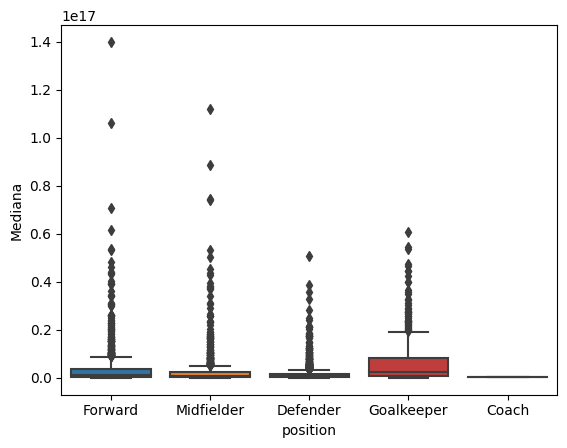

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(data=df_ligas, x="position", y="Mediana")
plt.show()

In [23]:
max_promedio = df_ligas['Mediana'].max()
df_max = df_ligas[df_ligas['Mediana'] == max_promedio]
df_max

,Player,age,position,Club,Valor1,Valor2,Valor3,Valor4,Valor5,Mediana
177,harry-kane,30,Forward,FC Bayern München,138500000000000000,158400000000000000,168000000000000000,140000000000000000,136800000000000000,1.400000e+17
